In [5]:
from scipy import stats, linalg
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dask
import dask.distributed
import pymc

In [6]:
sns.set_context("paper")

In [7]:
def make_matrix(rng, n_dim, eig_std, diag_std):
    #chol = pymc.LKJCholeskyCov.dist(eig_std, n_dim, pymc.LogitNormal.dist(sigma=diag_std))[0].eval()
    vecs = stats.ortho_group(n_dim, seed=rng).rvs()
    vals = np.exp(rng.normal(size=n_dim) * eig_std)
    diag = np.exp(rng.normal(size=n_dim) * diag_std / 2)
    return (vecs @ np.diag(vals) @ vecs.T) * diag[None, :] * diag[:, None]
    #return chol.T @ chol

def draw(rng, n_draws, cov):
    draws = rng.multivariate_normal(np.zeros_like(cov[0]), cov, size=n_draws)
    grads = -linalg.solve(cov, draws.T, assume_a="pos").T
    return draws, grads

In [8]:
def score(true_cov, approx):
    eigvals = linalg.eigvalsh(true_cov, approx)
    return np.sqrt(np.sqrt(((eigvals[-1] / eigvals) ** 2).sum()))
    #return np.sum(np.log(eigvals) ** 2)

In [9]:
def score_matrix(seed, n_dim, eig_std, diag_std, n_draws):
    rng = np.random.default_rng(seed)
    cov = make_matrix(rng, n_dim, eig_std, diag_std)
    draws, grads = draw(rng, n_draws, cov)
    diag_approx = np.diag(draws.var(0))
    score_old = score(cov, diag_approx)
    diag_approx = np.diag(np.sqrt(draws.var(0) / grads.var(0)))
    score_new = score(cov, diag_approx)
    return score_old, score_new

In [10]:
client = dask.distributed.Client(n_workers=10, threads_per_worker=1)
client

2022-10-05 19:30:41,845 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_inlqjxn', purging
2022-10-05 19:30:41,845 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8e26upao', purging
2022-10-05 19:30:41,846 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-416m6yhd', purging
2022-10-05 19:30:41,846 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-u2vzct2k', purging
2022-10-05 19:30:41,846 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-m83ohph0', purging
2022-10-05 19:30:41,846 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zrtj7oar', purging
2022-10-05 19:30:41,846 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kx4fxpey', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 94.24 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35279,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 94.24 GiB
Comm: tcp://127.0.0.1:41439,Total threads: 1
Dashboard: http://127.0.0.1:39813/status,Memory: 9.42 GiB
Nanny: tcp://127.0.0.1:34173,


In [11]:
rng = np.random.SeedSequence()
rng.entropy

78751457375910164741098992510909429363

In [14]:
n_draws_grid = [10, 20, 50]
eig_std_grid = [0.1, 0.25, 0.5]
#eig_std_grid = [100, 10, 1]

scores = []

rngs = rng.spawn(1000)
for i, n_draws in enumerate(n_draws_grid):
    scores_ = []
    for j, eig_std in enumerate(eig_std_grid):
        score_tasks = client.map(score_matrix, rngs, n_dim=200, eig_std=eig_std, diag_std=1, n_draws=n_draws)
        scores_current = [task.result() for task in score_tasks]
        scores_old, scores_new = zip(*scores_current)
        scores_.append((scores_old, scores_new))
    scores.append(scores_)

In [18]:
sns.set(font_scale=0.6)

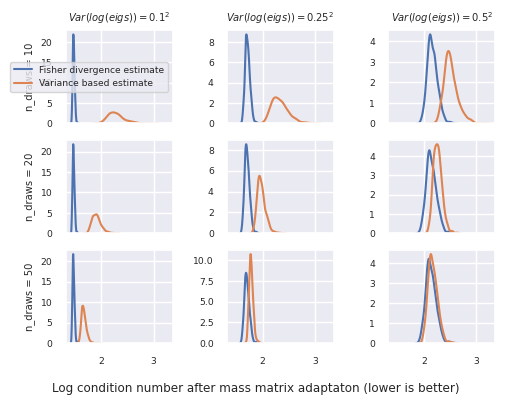

In [19]:
fig, axes = plt.subplots(len(n_draws_grid), len(eig_std_grid), sharex=True, figsize=(5, 4))

for i, n_draws in enumerate(n_draws_grid):
    for j, eig_std in enumerate(eig_std_grid):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(f"$Var(log(eigs)) = {eig_std:g}^2$")
        if j == 0:
            ax.set_ylabel(f"n_draws = {n_draws}")
        else:
            ax.set_ylabel(" ")
        scores_old, scores_new = scores[i][j]
        sns.kdeplot(np.log(scores_new), label="Fisher divergence estimate", ax=ax)
        sns.kdeplot(np.log(scores_old), label="Variance based estimate", ax=ax)
        if i == 0 and j == 0:
            ax.legend()

fig.supxlabel("Log condition number after mass matrix adaptaton (lower is better)")
fig.tight_layout()
fig.savefig("../figures/diag_condition_number.pdf")

In [23]:
s = np.array(scores)

In [24]:
s.shape

(3, 3, 2, 1000)

In [30]:
(s[:, :, 0, :] - s[:, :, 1, :]).min()

0.0013018483475857323